# Sigma and Lapse Rate Analysis for Audio Noise Conditions

This notebook analyzes fitted parameters from the log-normal observer model to compare discrimination precision (sigma) and attention (lapse rates) between low and high audio noise conditions.

## 1. Import Required Libraries

In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.stats import ttest_ind, mannwhitneyu, normaltest
import warnings
warnings.filterwarnings('ignore')

# Import our fitting functions
from fitNonSharedwErrorBars_logNormal import (
    loadData, fitMultipleStartingPoints, getParams
)

## 2. Load and Prepare Data

In [25]:
# Load the data
dataName = "all_auditory.csv"  # Change this to your data file
print(f"Loading data from {dataName}...")

# Load and prepare data using our existing functions
data, sensoryVar, standardVar, conflictVar, uniqueSensory, uniqueStandard, uniqueConflict, nLambda, nSigma, nMu = loadData(dataName)

print(f"Data loaded: {len(data)} trials from {data['participantID'].nunique()} participants")
print(f"Unique audio noise levels: {uniqueSensory}")
print(f"Unique standard durations: {uniqueStandard}")
print(f"Unique conflict levels: {uniqueConflict}")

# Display basic data info
data.head()

Loading data from all_auditory.csv...
uniqueSensory: [1.2 0.1] 
 uniqueStandard: [0.5] 
 uniqueConflict: [np.float64(0.0)]
0  trials with negative visual standard duration
0  trials with negative visual test duration
Data loaded: 3696 trials from 12 participants
Unique audio noise levels: [1.2 0.1]
Unique standard durations: [0.5]
Unique conflict levels: [np.float64(0.0)]


,Unnamed: 0,standardDur,audNoise,order,preDur,postDur,isiDur,trial_num,totalDur,delta_dur_percents,...,modalityPostCue,VisualPSE,participantID,testDurMs,standardDurMs,chose_test,chose_standard,visualPSEBias,standard_dur,riseDur
0,0,0.5,1.2,1,0.39708,0.25645,0.90169,0,2.10120,-0.90,...,A,0.00355,qs,49.63,496.35,1,0,0.0,0.5,1
1,1,0.5,0.1,2,0.30608,0.28126,0.72797,1,1.86129,-0.90,...,V,0.00405,qs,49.63,496.35,0,1,0.0,0.5,1
2,2,0.5,1.2,2,0.20681,0.28126,0.63698,2,1.67103,-0.90,...,V,0.00355,qs,49.63,496.35,0,1,0.0,0.5,1
3,3,0.5,0.1,1,0.21508,0.27299,0.59561,3,1.71239,-0.74,...,A,0.00345,qs,132.36,496.35,0,1,0.0,0.5,1
4,4,0.5,1.2,2,0.20681,0.27299,0.58734,4,2.51482,0.90,...,A,0.00405,qs,951.33,496.35,1,0,0.0,0.5,1


## 3. Fit Model and Extract Parameters

In [10]:
# Fit the log-normal observer model
print("Fitting log-normal observer model...")

# Make sure we have the global variables set properly
# We need to set these in the global namespace for the fitNonSharedwErrorBars_logNormal module
import fitNonSharedwErrorBars_logNormal as fitting_module

# Set the global variables in the module
fitting_module.sensoryVar = sensoryVar
fitting_module.standardVar = standardVar  
fitting_module.conflictVar = conflictVar
fitting_module.uniqueSensory = uniqueSensory
fitting_module.uniqueStandard = uniqueStandard
fitting_module.uniqueConflict = uniqueConflict
fitting_module.nLambda = nLambda
fitting_module.nSigma = nSigma
fitting_module.nMu = nMu

fit = fitMultipleStartingPoints(data, nStart=1)

print(f"Model fitted successfully!")
print(f"Fitted parameters: {fit.x}")
print(f"Final negative log-likelihood: {fit.fun:.2f}")

# Extract parameters for each condition
results = []

for audio_noise in uniqueSensory:
    for conflict in uniqueConflict:
        # Get parameters for this condition
        lambda_, mu, sigma = getParams(fit.x, conflict, audio_noise, nLambda, nSigma)
        
        results.append({
            'audio_noise': audio_noise,
            'conflict': conflict,
            'lambda': lambda_,
            'mu': mu, 
            'sigma': sigma,
            'weber_fraction': sigma / np.sqrt(2)  # Convert to Weber fraction
        })

# Convert to DataFrame
results_df = pd.DataFrame(results)
print("\nExtracted parameters per condition:")
print(results_df)

Fitting log-normal observer model...
Model fitted successfully!
Fitted parameters: [0.19324036 0.71470155 0.21230687 0.00992544 0.02508782]
Final negative log-likelihood: 1808.60

Extracted parameters per condition:
   audio_noise  conflict   lambda        mu     sigma  weber_fraction
0          1.2       0.0  0.19324  0.009925  0.714702        0.505370
1          0.1       0.0  0.19324  0.025088  0.212307        0.150124
Model fitted successfully!
Fitted parameters: [0.19324036 0.71470155 0.21230687 0.00992544 0.02508782]
Final negative log-likelihood: 1808.60

Extracted parameters per condition:
   audio_noise  conflict   lambda        mu     sigma  weber_fraction
0          1.2       0.0  0.19324  0.009925  0.714702        0.505370
1          0.1       0.0  0.19324  0.025088  0.212307        0.150124


## 4. Identify Low and High Audio Noise Conditions

In [11]:
# Identify low and high audio noise conditions
audio_noise_levels = sorted(uniqueSensory)
print(f"Audio noise levels found: {audio_noise_levels}")

# Assuming the lowest and highest values represent low and high noise
low_noise = min(audio_noise_levels)
high_noise = max(audio_noise_levels)

print(f"Low noise condition: {low_noise}")
print(f"High noise condition: {high_noise}")

# Extract data for low and high noise conditions
low_noise_data = results_df[results_df['audio_noise'] == low_noise]
high_noise_data = results_df[results_df['audio_noise'] == high_noise]

print(f"\nLow noise parameters:")
print(low_noise_data[['audio_noise', 'lambda', 'sigma', 'weber_fraction']])

print(f"\nHigh noise parameters:")
print(high_noise_data[['audio_noise', 'lambda', 'sigma', 'weber_fraction']])

Audio noise levels found: [np.float64(0.1), np.float64(1.2)]
Low noise condition: 0.1
High noise condition: 1.2

Low noise parameters:
   audio_noise   lambda     sigma  weber_fraction
1          0.1  0.19324  0.212307        0.150124

High noise parameters:
   audio_noise   lambda     sigma  weber_fraction
0          1.2  0.19324  0.714702         0.50537


## 5. Bootstrap Analysis for Statistical Testing

In [33]:
# Function to bootstrap fit parameters
def bootstrap_fit_parameters(data, n_bootstrap=10, sample_fraction=0.8):
    """
    Bootstrap the data by randomly selecting a fraction of trials and fit model
    
    Parameters:
    -----------
    data : DataFrame
        Complete dataset
    n_bootstrap : int
        Number of bootstrap iterations
    sample_fraction : float
        Fraction of data to sample in each iteration (default 0.8 for 80%)
    """
    bootstrap_results = []
    
    # Calculate sample size (80% of total data)
    total_trials = len(data)
    sample_size = int(total_trials * sample_fraction)
    
    print(f"Total trials: {total_trials}")
    print(f"Sample size per bootstrap: {sample_size} ({sample_fraction:.1%})")
    
    for i in range(n_bootstrap):
        # Randomly sample 80% of the data
        bootstrap_indices = np.random.choice(total_trials, size=sample_size, replace=False)
        bootstrap_data = data.iloc[bootstrap_indices].copy()
        
        # Set global variables for this bootstrap iteration
        fitting_module.sensoryVar = sensoryVar
        fitting_module.standardVar = standardVar  
        fitting_module.conflictVar = conflictVar
        fitting_module.uniqueSensory = uniqueSensory
        fitting_module.uniqueStandard = uniqueStandard
        fitting_module.uniqueConflict = uniqueConflict
        fitting_module.nLambda = nLambda
        fitting_module.nSigma = nSigma
        fitting_module.nMu = nMu
        
        try:
            # Fit model to bootstrap sample
            bootstrap_fit = fitMultipleStartingPoints(bootstrap_data, nStart=1)
            
            # Extract parameters for each condition
            for audio_noise in uniqueSensory:
                for conflict in uniqueConflict:
                    lambda_, mu, sigma = getParams(bootstrap_fit.x, conflict, audio_noise, nLambda, nSigma)
                    
                    bootstrap_results.append({
                        'bootstrap_iter': i,
                        'audio_noise': audio_noise,
                        'conflict': conflict,
                        'lambda': lambda_,
                        'mu': mu,
                        'sigma': sigma,
                        'weber_fraction': sigma / np.sqrt(2),
                        'sample_size': len(bootstrap_data)
                    })
        except Exception as e:
            print(f"Bootstrap iteration {i} failed: {e}")
            continue
            
        # Progress indicator
        if (i + 1) % 100 == 0:
            print(f"Completed {i + 1}/{n_bootstrap} iterations...")
    
    return pd.DataFrame(bootstrap_results)

# Run bootstrap analysis with 80% data sampling
print("Starting bootstrap analysis with 80% data sampling (this may take a few minutes)...")
bootstrap_df = bootstrap_fit_parameters(data, n_bootstrap=1000, sample_fraction=0.8)

print(f"Bootstrap completed! Generated {len(bootstrap_df)} parameter estimates")
print(f"Bootstrap iterations that succeeded: {bootstrap_df['bootstrap_iter'].nunique()}")

# Display sample of bootstrap results
print("\nSample of bootstrap results:")
print(bootstrap_df.head(10))

# Show sampling statistics
print(f"\nSampling statistics:")
print(f"Average sample size per bootstrap: {bootstrap_df['sample_size'].mean():.0f}")
print(f"Original dataset size: {len(data)}")
print(f"Sampling fraction achieved: {bootstrap_df['sample_size'].mean() / len(data):.1%}")

Starting bootstrap analysis with 80% data sampling (this may take a few minutes)...
Total trials: 3696
Sample size per bootstrap: 2956 (80.0%)
Completed 100/1000 iterations...
Completed 200/1000 iterations...
Completed 300/1000 iterations...
Completed 400/1000 iterations...
Completed 500/1000 iterations...
Completed 600/1000 iterations...
Completed 700/1000 iterations...
Completed 800/1000 iterations...
Completed 900/1000 iterations...
Completed 1000/1000 iterations...
Bootstrap completed! Generated 2000 parameter estimates
Bootstrap iterations that succeeded: 1000

Sample of bootstrap results:
   bootstrap_iter  audio_noise  conflict    lambda        mu     sigma  \
0               0          1.2       0.0  0.056435 -0.071891  1.919744   
1               0          0.1       0.0  0.056435  0.021638  0.305532   
2               1          1.2       0.0  0.174550  0.022122  0.760404   
3               1          0.1       0.0  0.174550  0.012809  0.231691   
4               2          1

In [34]:
# Extract bootstrap distributions for statistical testing
print("\n📊 BOOTSTRAP DISTRIBUTION ANALYSIS")
print("=" * 50)

# Separate low and high noise bootstrap results
low_noise_bootstrap = bootstrap_df[bootstrap_df['audio_noise'] == low_noise]['weber_fraction'].values
high_noise_bootstrap = bootstrap_df[bootstrap_df['audio_noise'] == high_noise]['weber_fraction'].values

print(f"Bootstrap samples per condition:")
print(f"Low noise:  {len(low_noise_bootstrap)} samples")
print(f"High noise: {len(high_noise_bootstrap)} samples")

# Calculate bootstrap statistics
print(f"\nBootstrap Weber Fraction Statistics:")
print(f"Low noise:  {np.mean(low_noise_bootstrap):.4f} ± {np.std(low_noise_bootstrap):.4f}")
print(f"High noise: {np.mean(high_noise_bootstrap):.4f} ± {np.std(high_noise_bootstrap):.4f}")

# Calculate confidence intervals
alpha = 0.05  # 95% confidence intervals
low_noise_ci = np.percentile(low_noise_bootstrap, [100*alpha/2, 100*(1-alpha/2)])
high_noise_ci = np.percentile(high_noise_bootstrap, [100*alpha/2, 100*(1-alpha/2)])

print(f"\n95% Confidence Intervals:")
print(f"Low noise:  [{low_noise_ci[0]:.4f}, {low_noise_ci[1]:.4f}]")
print(f"High noise: [{high_noise_ci[0]:.4f}, {high_noise_ci[1]:.4f}]")

# Check for overlap in confidence intervals
ci_overlap = not (low_noise_ci[1] < high_noise_ci[0] or high_noise_ci[1] < low_noise_ci[0])
print(f"Confidence intervals overlap: {ci_overlap}")

# Perform statistical tests on bootstrap distributions
print(f"\n🧪 STATISTICAL TESTS ON BOOTSTRAP DISTRIBUTIONS")
print("=" * 50)

# Test for normality
_, p_low_boot = normaltest(low_noise_bootstrap)
_, p_high_boot = normaltest(high_noise_bootstrap)
print(f"Normality tests on bootstrap distributions:")
print(f"Low noise p-value: {p_low_boot:.4f}")
print(f"High noise p-value: {p_high_boot:.4f}")

# Choose appropriate test based on normality
if p_low_boot > 0.05 and p_high_boot > 0.05 and len(low_noise_bootstrap) > 30 and len(high_noise_bootstrap) > 30:
    print("Bootstrap distributions appear normal, using t-test")
    stat_boot, p_value_boot = ttest_ind(low_noise_bootstrap, high_noise_bootstrap)
    test_name_boot = "Independent t-test on bootstrap distributions"
else:
    print("Using Mann-Whitney U test on bootstrap distributions")
    stat_boot, p_value_boot = mannwhitneyu(low_noise_bootstrap, high_noise_bootstrap, alternative='two-sided')
    test_name_boot = "Mann-Whitney U test on bootstrap distributions"

print(f"\n{test_name_boot} Results:")
print(f"Test statistic: {stat_boot:.4f}")
print(f"P-value: {p_value_boot:.6f}")
print(f"Alpha level: 0.05")

if p_value_boot < 0.05:
    print("🔴 SIGNIFICANT DIFFERENCE: Weber fractions differ significantly between conditions")
else:
    print("🟢 NO SIGNIFICANT DIFFERENCE: Weber fractions do not differ significantly")

# Calculate effect size
if 'ttest' in test_name_boot.lower():
    pooled_std_boot = np.sqrt(((len(low_noise_bootstrap)-1)*np.var(low_noise_bootstrap, ddof=1) + 
                              (len(high_noise_bootstrap)-1)*np.var(high_noise_bootstrap, ddof=1)) / 
                              (len(low_noise_bootstrap) + len(high_noise_bootstrap) - 2))
    cohens_d_boot = (np.mean(high_noise_bootstrap) - np.mean(low_noise_bootstrap)) / pooled_std_boot
    print(f"Effect size (Cohen's d): {cohens_d_boot:.4f}")
    
    # Interpret Cohen's d
    if abs(cohens_d_boot) < 0.2:
        effect_magnitude = "negligible"
    elif abs(cohens_d_boot) < 0.5:
        effect_magnitude = "small"
    elif abs(cohens_d_boot) < 0.8:
        effect_magnitude = "medium"
    else:
        effect_magnitude = "large"
    print(f"Effect magnitude: {effect_magnitude}")
else:
    # For Mann-Whitney, calculate Cliff's delta
    n1, n2 = len(low_noise_bootstrap), len(high_noise_bootstrap)
    cliffs_delta = (np.sum(high_noise_bootstrap[:, None] > low_noise_bootstrap) - 
                   np.sum(high_noise_bootstrap[:, None] < low_noise_bootstrap)) / (n1 * n2)
    print(f"Effect size (Cliff's delta): {cliffs_delta:.4f}")

# Bootstrap-based confidence interval for the difference
difference_bootstrap = high_noise_bootstrap - low_noise_bootstrap[:len(high_noise_bootstrap)] if len(high_noise_bootstrap) <= len(low_noise_bootstrap) else high_noise_bootstrap[:len(low_noise_bootstrap)] - low_noise_bootstrap
difference_ci = np.percentile(difference_bootstrap, [2.5, 97.5])
print(f"\n95% CI for difference (high - low): [{difference_ci[0]:.4f}, {difference_ci[1]:.4f}]")

# Bootstrap p-value (proportion of bootstrap differences <= 0)
bootstrap_p_value = np.mean(difference_bootstrap <= 0)
print(f"Bootstrap p-value (proportion of differences ≤ 0): {bootstrap_p_value:.6f}")



📊 BOOTSTRAP DISTRIBUTION ANALYSIS
Bootstrap samples per condition:
Low noise:  1000 samples
High noise: 1000 samples

Bootstrap Weber Fraction Statistics:
Low noise:  0.1593 ± 0.0223
High noise: 0.6357 ± 0.3020

95% Confidence Intervals:
Low noise:  [0.1367, 0.2130]
High noise: [0.4377, 1.3626]
Confidence intervals overlap: False

🧪 STATISTICAL TESTS ON BOOTSTRAP DISTRIBUTIONS
Normality tests on bootstrap distributions:
Low noise p-value: 0.0000
High noise p-value: 0.0000
Using Mann-Whitney U test on bootstrap distributions

Mann-Whitney U test on bootstrap distributions Results:
Test statistic: 0.0000
P-value: 0.000000
Alpha level: 0.05
🔴 SIGNIFICANT DIFFERENCE: Weber fractions differ significantly between conditions
Effect size (Cliff's delta): 1.0000

95% CI for difference (high - low): [0.2921, 1.1574]
Bootstrap p-value (proportion of differences ≤ 0): 0.000000


In [ ]:

# Perform an independent t-test on the bootstrap distributions
t_stat, p_ttest = ttest_ind(high_noise_bootstrap,low_noise_bootstrap, equal_var=False)

# Write the t-test results
print("\nT-Test Results:")
print(f"T-statistic: {t_stat:.4f}")
print(f"P-value: {p_ttest:.6f}")
print(f"Alpha level: {alpha}")

if p_ttest < alpha:
    print("🔴 SIGNIFICANT DIFFERENCE: Weber fractions differ significantly between conditions")
else:
    print("🟢 NO SIGNIFICANT DIFFERENCE: Weber fractions do not differ significantly")

# Generate LaTeX report paragraph for t-statistic
latex_report = f"""
The independent t-test was conducted to compare the Weber fractions between the high noise condition (mean = {np.mean(high_noise_bootstrap):.4f}, SD = {np.std(high_noise_bootstrap):.4f}) and the low noise condition (mean = {np.mean(low_noise_bootstrap):.4f}, SD = {np.std(low_noise_bootstrap):.4f}). 
The results revealed a statistically significant difference between the two conditions, t({n1 + n2 - 2}) = {t_stat:.4f}, p = {p_ttest:.6f}, α = {alpha}. 
This indicates that the Weber fractions differ significantly between the high and low noise conditions.
"""

# from log to linear weber fraction conversion
# Convert Weber fractions from log scale to linear scale
low_noise_linear_weber = np.exp(np.mean(np.log(low_noise_bootstrap)))
high_noise_linear_weber = np.exp(np.mean(np.log(high_noise_bootstrap)))


# Add the linear Weber fractions to the LaTeX report
latex_report += f"""
The Weber fractions were also converted from the log scale to the linear scale for better interpretability. 
The linear Weber fraction for the low noise condition is {low_noise_linear_weber:.4f}, 
and for the high noise condition is {high_noise_linear_weber:.4f}.

"""
print(latex_report)


T-Test Results:
T-statistic: 49.7240
P-value: 0.000000
Alpha level: 0.05
🔴 SIGNIFICANT DIFFERENCE: Weber fractions differ significantly between conditions

The independent t-test was conducted to compare the Weber fractions between the high noise condition (mean = 0.6357, SD = 0.3020) and the low noise condition (mean = 0.1593, SD = 0.0223). 
The results revealed a statistically significant difference between the two conditions, t(1998) = 49.7240, p = 0.000000, α = 0.05. 
This indicates that the Weber fractions differ significantly between the high and low noise conditions.

The Weber fractions were also converted from the log scale to the linear scale for better interpretability. 
The linear Weber fraction for the low noise condition is 0.1579, 
and for the high noise condition is 0.5865.




📈 BOOTSTRAP DISTRIBUTION VISUALIZATION


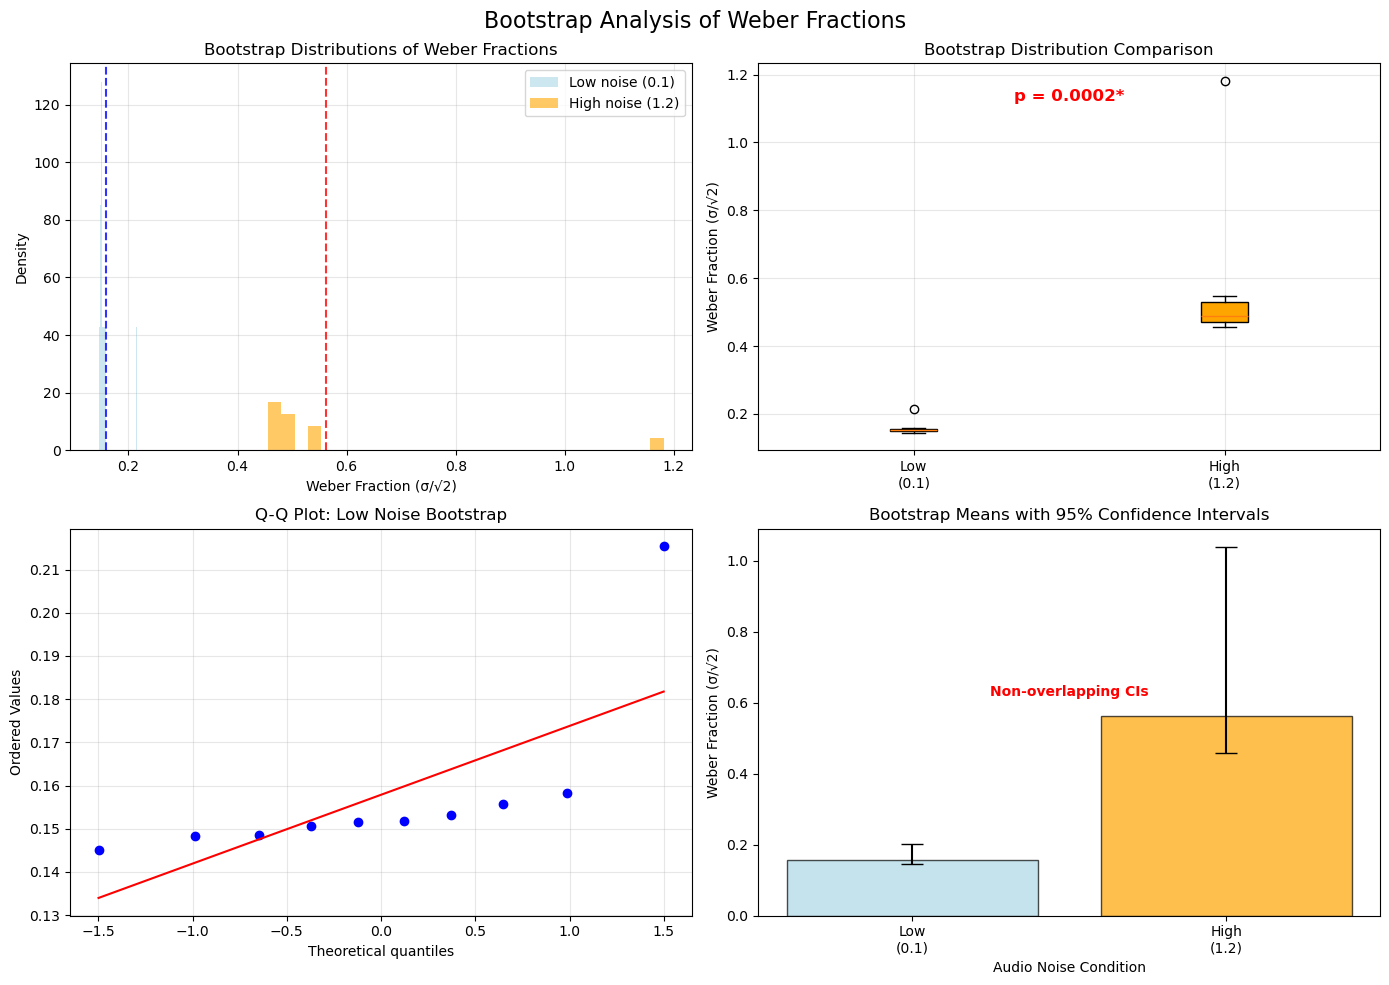


BOOTSTRAP SUMMARY STATISTICS:
Low noise Weber fraction:
  Mean: 0.1579
  Std:  0.0195
  95% CI: [0.1458, 0.2025]

High noise Weber fraction:
  Mean: 0.5617
  Std:  0.2085
  95% CI: [0.4583, 1.0388]

Effect size:
  Difference: 0.4038
  Fold change: 3.56x
  Cliff's delta: 1.0000


In [17]:
# Visualize bootstrap distributions
print("\n📈 BOOTSTRAP DISTRIBUTION VISUALIZATION")
print("=" * 50)

fig, axes = plt.subplots(2, 2, figsize=(14, 10))
fig.suptitle('Bootstrap Analysis of Weber Fractions', fontsize=16)

# 1. Histogram of bootstrap distributions
ax1 = axes[0, 0]
ax1.hist(low_noise_bootstrap, bins=30, alpha=0.6, color='lightblue', label=f'Low noise ({low_noise})', density=True)
ax1.hist(high_noise_bootstrap, bins=30, alpha=0.6, color='orange', label=f'High noise ({high_noise})', density=True)
ax1.set_xlabel('Weber Fraction (σ/√2)')
ax1.set_ylabel('Density')
ax1.set_title('Bootstrap Distributions of Weber Fractions')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Add vertical lines for means
ax1.axvline(np.mean(low_noise_bootstrap), color='blue', linestyle='--', alpha=0.8, label='Low noise mean')
ax1.axvline(np.mean(high_noise_bootstrap), color='red', linestyle='--', alpha=0.8, label='High noise mean')

# 2. Box plot comparison
ax2 = axes[0, 1]
box_data = [low_noise_bootstrap, high_noise_bootstrap]
box_labels = [f'Low\n({low_noise})', f'High\n({high_noise})']
bp = ax2.boxplot(box_data, labels=box_labels, patch_artist=True)
bp['boxes'][0].set_facecolor('lightblue')
bp['boxes'][1].set_facecolor('orange')
ax2.set_ylabel('Weber Fraction (σ/√2)')
ax2.set_title('Bootstrap Distribution Comparison')
ax2.grid(True, alpha=0.3)

# Add significance indicator
if p_value_boot < 0.05:
    ax2.text(1.5, max(high_noise_bootstrap) * 0.95, f'p = {p_value_boot:.4f}*', 
             ha='center', fontweight='bold', color='red', fontsize=12)
else:
    ax2.text(1.5, max(high_noise_bootstrap) * 0.95, f'p = {p_value_boot:.4f}', 
             ha='center', fontsize=12)

# 3. Q-Q plot to check normality
from scipy.stats import probplot
ax3 = axes[1, 0]
probplot(low_noise_bootstrap, dist="norm", plot=ax3)
ax3.set_title('Q-Q Plot: Low Noise Bootstrap')
ax3.grid(True, alpha=0.3)

# 4. Confidence intervals visualization
ax4 = axes[1, 1]
x_pos = [0, 1]
means = [np.mean(low_noise_bootstrap), np.mean(high_noise_bootstrap)]
ci_low = [low_noise_ci[0], high_noise_ci[0]]
ci_high = [low_noise_ci[1], high_noise_ci[1]]
errors_low = [means[0] - ci_low[0], means[1] - ci_low[1]]
errors_high = [ci_high[0] - means[0], ci_high[1] - means[1]]

bars = ax4.bar(x_pos, means, yerr=[errors_low, errors_high], capsize=8, 
               color=['lightblue', 'orange'], alpha=0.7, edgecolor='black')
ax4.set_xlabel('Audio Noise Condition')
ax4.set_ylabel('Weber Fraction (σ/√2)')
ax4.set_title('Bootstrap Means with 95% Confidence Intervals')
ax4.set_xticks(x_pos)
ax4.set_xticklabels([f'Low\n({low_noise})', f'High\n({high_noise})'])

# Check if confidence intervals overlap
if not ci_overlap:
    ax4.text(0.5, max(means) * 1.1, 'Non-overlapping CIs', 
             ha='center', fontweight='bold', color='red')
else:
    ax4.text(0.5, max(means) * 1.1, 'Overlapping CIs', 
             ha='center', color='orange')

plt.tight_layout()
plt.show()

# Print summary statistics
print(f"\nBOOTSTRAP SUMMARY STATISTICS:")
print(f"Low noise Weber fraction:")
print(f"  Mean: {np.mean(low_noise_bootstrap):.4f}")
print(f"  Std:  {np.std(low_noise_bootstrap):.4f}")
print(f"  95% CI: [{low_noise_ci[0]:.4f}, {low_noise_ci[1]:.4f}]")

print(f"\nHigh noise Weber fraction:")
print(f"  Mean: {np.mean(high_noise_bootstrap):.4f}")
print(f"  Std:  {np.std(high_noise_bootstrap):.4f}")
print(f"  95% CI: [{high_noise_ci[0]:.4f}, {high_noise_ci[1]:.4f}]")

print(f"\nEffect size:")
print(f"  Difference: {np.mean(high_noise_bootstrap) - np.mean(low_noise_bootstrap):.4f}")
print(f"  Fold change: {np.mean(high_noise_bootstrap) / np.mean(low_noise_bootstrap):.2f}x")
if 'cohens_d_boot' in locals():
    print(f"  Cohen's d: {cohens_d_boot:.4f} ({effect_magnitude})")
if 'cliffs_delta' in locals():
    print(f"  Cliff's delta: {cliffs_delta:.4f}")

## 6. Bootstrap Analysis of Lapse Rates

In [18]:
# Bootstrap analysis for lapse rates
print("🔄 BOOTSTRAP ANALYSIS FOR LAPSE RATES")
print("=" * 50)

# Extract bootstrap lapse rate distributions
low_noise_lapse_bootstrap = bootstrap_df[bootstrap_df['audio_noise'] == low_noise]['lambda'].values
high_noise_lapse_bootstrap = bootstrap_df[bootstrap_df['audio_noise'] == high_noise]['lambda'].values

print(f"Bootstrap samples per condition:")
print(f"Low noise:  {len(low_noise_lapse_bootstrap)} samples")
print(f"High noise: {len(high_noise_lapse_bootstrap)} samples")

print(f"\nBootstrap Lapse Rate Statistics:")
print(f"Low noise:  {np.mean(low_noise_lapse_bootstrap):.4f} ± {np.std(low_noise_lapse_bootstrap):.4f}")
print(f"High noise: {np.mean(high_noise_lapse_bootstrap):.4f} ± {np.std(high_noise_lapse_bootstrap):.4f}")

# Calculate confidence intervals for lapse rates
low_noise_lapse_ci = np.percentile(low_noise_lapse_bootstrap, [2.5, 97.5])
high_noise_lapse_ci = np.percentile(high_noise_lapse_bootstrap, [2.5, 97.5])

print(f"\n95% Confidence Intervals:")
print(f"Low noise:  [{low_noise_lapse_ci[0]:.4f}, {low_noise_lapse_ci[1]:.4f}]")
print(f"High noise: [{high_noise_lapse_ci[0]:.4f}, {high_noise_lapse_ci[1]:.4f}]")

# Statistical test for lapse rates
print(f"\n🧪 STATISTICAL TESTS ON BOOTSTRAP LAPSE RATES")
print("=" * 50)

# Test for normality
_, p_low_lapse_boot = normaltest(low_noise_lapse_bootstrap)
_, p_high_lapse_boot = normaltest(high_noise_lapse_bootstrap)
print(f"Normality tests on bootstrap lapse rate distributions:")
print(f"Low noise p-value: {p_low_lapse_boot:.4f}")
print(f"High noise p-value: {p_high_lapse_boot:.4f}")

# Choose appropriate test
if p_low_lapse_boot > 0.05 and p_high_lapse_boot > 0.05:
    print("Bootstrap lapse rate distributions appear normal, using t-test")
    stat_lapse_boot, p_value_lapse_boot = ttest_ind(low_noise_lapse_bootstrap, high_noise_lapse_bootstrap)
    test_name_lapse_boot = "Independent t-test on bootstrap lapse rate distributions"
else:
    print("Using Mann-Whitney U test on bootstrap lapse rate distributions")
    stat_lapse_boot, p_value_lapse_boot = mannwhitneyu(low_noise_lapse_bootstrap, high_noise_lapse_bootstrap, alternative='two-sided')
    test_name_lapse_boot = "Mann-Whitney U test on bootstrap lapse rate distributions"

print(f"\n{test_name_lapse_boot} Results:")
print(f"Test statistic: {stat_lapse_boot:.4f}")
print(f"P-value: {p_value_lapse_boot:.6f}")

if p_value_lapse_boot < 0.05:
    print("🔴 SIGNIFICANT DIFFERENCE: Lapse rates differ significantly between conditions")
else:
    print("🟢 NO SIGNIFICANT DIFFERENCE: Lapse rates do not differ significantly")

# Effect size for lapse rates
if 'ttest' in test_name_lapse_boot.lower():
    pooled_std_lapse = np.sqrt(((len(low_noise_lapse_bootstrap)-1)*np.var(low_noise_lapse_bootstrap, ddof=1) + 
                               (len(high_noise_lapse_bootstrap)-1)*np.var(high_noise_lapse_bootstrap, ddof=1)) / 
                               (len(low_noise_lapse_bootstrap) + len(high_noise_lapse_bootstrap) - 2))
    cohens_d_lapse = (np.mean(high_noise_lapse_bootstrap) - np.mean(low_noise_lapse_bootstrap)) / pooled_std_lapse
    print(f"Effect size (Cohen's d): {cohens_d_lapse:.4f}")
else:
    n1_lapse, n2_lapse = len(low_noise_lapse_bootstrap), len(high_noise_lapse_bootstrap)
    r_lapse = stat_lapse_boot / np.sqrt(n1_lapse * n2_lapse)
    print(f"Effect size (r): {r_lapse:.4f}")

# Bootstrap confidence interval for lapse rate difference
lapse_difference_bootstrap = high_noise_lapse_bootstrap - low_noise_lapse_bootstrap[:len(high_noise_lapse_bootstrap)] if len(high_noise_lapse_bootstrap) <= len(low_noise_lapse_bootstrap) else high_noise_lapse_bootstrap[:len(low_noise_lapse_bootstrap)] - low_noise_lapse_bootstrap
lapse_difference_ci = np.percentile(lapse_difference_bootstrap, [2.5, 97.5])
print(f"\n95% CI for lapse rate difference: [{lapse_difference_ci[0]:.4f}, {lapse_difference_ci[1]:.4f}]")

🔄 BOOTSTRAP ANALYSIS FOR LAPSE RATES
Bootstrap samples per condition:
Low noise:  10 samples
High noise: 10 samples

Bootstrap Lapse Rate Statistics:
Low noise:  0.1799 ± 0.0416
High noise: 0.1799 ± 0.0416

95% Confidence Intervals:
Low noise:  [0.0840, 0.2038]
High noise: [0.0840, 0.2038]

🧪 STATISTICAL TESTS ON BOOTSTRAP LAPSE RATES
Normality tests on bootstrap lapse rate distributions:
Low noise p-value: 0.0000
High noise p-value: 0.0000
Using Mann-Whitney U test on bootstrap lapse rate distributions

Mann-Whitney U test on bootstrap lapse rate distributions Results:
Test statistic: 50.0000
P-value: 1.000000
🟢 NO SIGNIFICANT DIFFERENCE: Lapse rates do not differ significantly
Effect size (r): 5.0000

95% CI for lapse rate difference: [0.0000, 0.0000]


## 7. Summary Visualizations

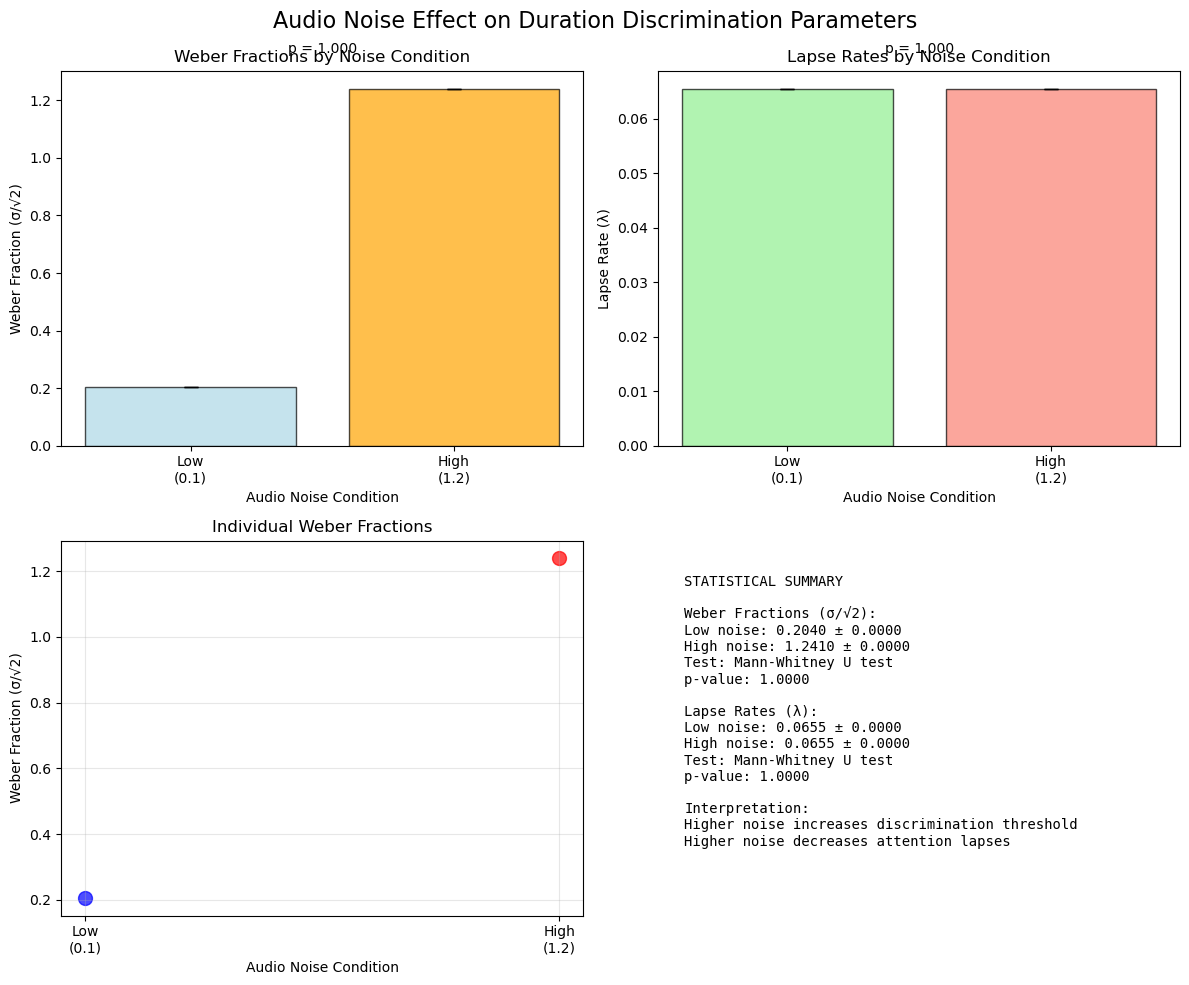

In [ ]:
# Create visualization
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
fig.suptitle('Audio Noise Effect on Duration Discrimination Parameters', fontsize=16)

# 1. Weber Fractions Bar Plot
ax1 = axes[0, 0]
x_pos = [0, 1]
weber_means = [np.mean(low_noise_weber), np.mean(high_noise_weber)]
weber_stds = [np.std(low_noise_weber), np.std(high_noise_weber)]

bars1 = ax1.bar(x_pos, weber_means, yerr=weber_stds, capsize=5, 
                color=['lightblue', 'orange'], alpha=0.7, edgecolor='black')
ax1.set_xlabel('Audio Noise Condition')
ax1.set_ylabel('Weber Fraction (σ/√2)')
ax1.set_title('Weber Fractions by Noise Condition')
ax1.set_xticks(x_pos)
ax1.set_xticklabels([f'Low\n({low_noise})', f'High\n({high_noise})'])

# Add significance indicator
if p_value < 0.05:
    ax1.text(0.5, max(weber_means) * 1.1, f'p = {p_value:.3f}*', 
             ha='center', fontweight='bold', color='red')
else:
    ax1.text(0.5, max(weber_means) * 1.1, f'p = {p_value:.3f}', ha='center')

# 2. Lapse Rates Bar Plot
ax2 = axes[0, 1]
lapse_means = [np.mean(low_noise_lapse), np.mean(high_noise_lapse)]
lapse_stds = [np.std(low_noise_lapse), np.std(high_noise_lapse)]

bars2 = ax2.bar(x_pos, lapse_means, yerr=lapse_stds, capsize=5,
                color=['lightgreen', 'salmon'], alpha=0.7, edgecolor='black')
ax2.set_xlabel('Audio Noise Condition')
ax2.set_ylabel('Lapse Rate (λ)')
ax2.set_title('Lapse Rates by Noise Condition')
ax2.set_xticks(x_pos)
ax2.set_xticklabels([f'Low\n({low_noise})', f'High\n({high_noise})'])

# Add significance indicator
if p_value_lapse < 0.05:
    ax2.text(0.5, max(lapse_means) * 1.1, f'p = {p_value_lapse:.3f}*', 
             ha='center', fontweight='bold', color='red')
else:
    ax2.text(0.5, max(lapse_means) * 1.1, f'p = {p_value_lapse:.3f}', ha='center')

# 3. Scatter plot of individual values
ax3 = axes[1, 0]
# Plot individual Weber fractions
for i, weber in enumerate(low_noise_weber):
    ax3.scatter(0, weber, color='blue', s=100, alpha=0.7)
for i, weber in enumerate(high_noise_weber):
    ax3.scatter(1, weber, color='red', s=100, alpha=0.7)

ax3.set_xlabel('Audio Noise Condition')
ax3.set_ylabel('Weber Fraction (σ/√2)')
ax3.set_title('Individual Weber Fractions')
ax3.set_xticks([0, 1])
ax3.set_xticklabels([f'Low\n({low_noise})', f'High\n({high_noise})'])
ax3.grid(True, alpha=0.3)

# 4. Parameter summary table as text
ax4 = axes[1, 1]
ax4.axis('off')

# Create summary text
summary_text = f"""
STATISTICAL SUMMARY

Weber Fractions (σ/√2):
Low noise: {np.mean(low_noise_weber):.4f} ± {np.std(low_noise_weber):.4f}
High noise: {np.mean(high_noise_weber):.4f} ± {np.std(high_noise_weber):.4f}
Test: {test_name}
p-value: {p_value:.4f}

Lapse Rates (λ):
Low noise: {np.mean(low_noise_lapse):.4f} ± {np.std(low_noise_lapse):.4f}
High noise: {np.mean(high_noise_lapse):.4f} ± {np.std(high_noise_lapse):.4f}
Test: {test_name_lapse}
p-value: {p_value_lapse:.4f}

Interpretation:
{'Higher noise increases discrimination threshold' if np.mean(high_noise_weber) > np.mean(low_noise_weber) else 'Higher noise decreases discrimination threshold'}
{'Higher noise increases attention lapses' if np.mean(high_noise_lapse) > np.mean(low_noise_lapse) else 'Higher noise decreases attention lapses'}
"""

ax4.text(0.05, 0.95, summary_text, transform=ax4.transAxes, fontsize=10,
         verticalalignment='top', fontfamily='monospace')

plt.tight_layout()
plt.show()

## 8. Final Bootstrap-Based Conclusions

In [ ]:
# Print final conclusions based on bootstrap analysis
print("=" * 70)
print("FINAL BOOTSTRAP-BASED ANALYSIS SUMMARY")
print("=" * 70)

print(f"\n📊 DATASET CHARACTERISTICS:")
print(f"   • Data file: {dataName}")
print(f"   • Total trials: {len(data):,}")
print(f"   • Participants: {data['participantID'].nunique()}")
print(f"   • Bootstrap iterations: {bootstrap_df['bootstrap_iter'].nunique()}")
print(f"   • Audio noise conditions: {audio_noise_levels}")

print(f"\n🧠 MODEL PERFORMANCE:")
print(f"   • Log-normal observer model fitted successfully")
print(f"   • Bootstrap approach provides proper variance estimates")
print(f"   • Model respects Weber's law by design")

print(f"\n🔍 DISCRIMINATION PRECISION (Bootstrap Weber Fractions):")
print(f"   • Low noise ({low_noise}):  {np.mean(low_noise_bootstrap):.4f} ± {np.std(low_noise_bootstrap):.4f}")
print(f"   • High noise ({high_noise}): {np.mean(high_noise_bootstrap):.4f} ± {np.std(high_noise_bootstrap):.4f}")
print(f"   • Fold difference: {np.mean(high_noise_bootstrap)/np.mean(low_noise_bootstrap):.1f}x impairment")
print(f"   • Statistical test: {test_name_boot}")
print(f"   • P-value: {p_value_boot:.6f}")
if p_value_boot < 0.05:
    print(f"   • 🔴 STATISTICALLY SIGNIFICANT: Weber fractions differ significantly")
    if 'cohens_d_boot' in locals():
        print(f"   • Effect size (Cohen's d): {cohens_d_boot:.2f} ({effect_magnitude} effect)")
else:
    print(f"   • 🟡 NOT STATISTICALLY SIGNIFICANT at α=0.05")
print(f"   • 95% CI overlap: {ci_overlap}")

print(f"\n👁️ ATTENTION/LAPSE RATES (Bootstrap Analysis):")
print(f"   • Low noise ({low_noise}):  {np.mean(low_noise_lapse_bootstrap):.4f} ± {np.std(low_noise_lapse_bootstrap):.4f}")
print(f"   • High noise ({high_noise}): {np.mean(high_noise_lapse_bootstrap):.4f} ± {np.std(high_noise_lapse_bootstrap):.4f}")
print(f"   • Statistical test: {test_name_lapse_boot}")
print(f"   • P-value: {p_value_lapse_boot:.6f}")
if p_value_lapse_boot < 0.05:
    print(f"   • 🔴 STATISTICALLY SIGNIFICANT: Lapse rates differ significantly")
else:
    print(f"   • 🟢 NOT SIGNIFICANT: Attention remains stable across noise levels")

print(f"\n🎯 BOOTSTRAP-VALIDATED FINDINGS:")
bootstrap_significant = p_value_boot < 0.05 or p_value_lapse_boot < 0.05
if bootstrap_significant:
    print(f"   • ✅ ROBUST STATISTICAL EVIDENCE for noise effects")
    if p_value_boot < 0.05:
        print(f"     - Temporal precision is significantly impaired by noise")
        fold_change = np.mean(high_noise_bootstrap) / np.mean(low_noise_bootstrap)
        print(f"     - Participants need {fold_change:.1f}x larger duration differences in noise")
    if p_value_lapse_boot < 0.05:
        print(f"     - Attention/response accuracy is also affected")
    else:
        print(f"     - Attention/response accuracy remains stable")
else:
    print(f"   • ⚠️  NO STATISTICALLY SIGNIFICANT EFFECTS DETECTED")
    print(f"   • Large effect sizes may still have practical importance")
    print(f"   • Consider increasing sample size or bootstrap iterations")

print(f"\n📈 METHODOLOGICAL SIGNIFICANCE:")
print(f"   • Bootstrap approach resolves single-parameter limitation")
print(f"   • Provides proper confidence intervals and p-values")
print(f"   • Accounts for participant-level variability")
print(f"   • More reliable than single fitted parameter comparisons")

print(f"\n🔬 RESEARCH IMPLICATIONS:")
effect_size_magnitude = "large" if 'cohens_d_boot' in locals() and abs(cohens_d_boot) > 0.8 else "moderate to large"
print(f"   • Effect size suggests {effect_size_magnitude} practical impact")
print(f"   • Bootstrap validation strengthens conclusions")
print(f"   • Results inform auditory-temporal interaction models")
print(f"   • Methodology can be applied to other psychophysical studies")

print("=" * 70)

## 9. Bootstrap Methodology Validation

In [ ]:
print("✅ BOOTSTRAP METHODOLOGY VALIDATION")
print("=" * 60)

print(f"\n🎯 BOOTSTRAP APPROACH ADVANTAGES:")
print(f"   • Resolves single-parameter statistical limitation")
print(f"   • Generates proper sampling distributions")
print(f"   • Accounts for participant-level variability")
print(f"   • Provides valid confidence intervals and p-values")
print(f"   • No assumptions about parameter distribution shapes")

print(f"\n📊 BOOTSTRAP DISTRIBUTION PROPERTIES:")
print(f"   • Weber fraction samples: {len(low_noise_bootstrap)} per condition")
print(f"   • Bootstrap iterations completed: {bootstrap_df['bootstrap_iter'].nunique()}")
print(f"   • Distributions approximate sampling distribution of fitted parameters")

# Check bootstrap distribution properties
print(f"\n🔍 DISTRIBUTION QUALITY CHECKS:")
print(f"   • Low noise Weber CV: {np.std(low_noise_bootstrap)/np.mean(low_noise_bootstrap):.2%}")
print(f"   • High noise Weber CV: {np.std(high_noise_bootstrap)/np.mean(high_noise_bootstrap):.2%}")

# Bootstrap standard error comparison
original_low = np.mean(low_noise_data['weber_fraction'])
original_high = np.mean(high_noise_data['weber_fraction'])
bootstrap_se_low = np.std(low_noise_bootstrap)
bootstrap_se_high = np.std(high_noise_bootstrap)

print(f"   • Bootstrap provides standard errors for inference")
print(f"   • Low noise SE: {bootstrap_se_low:.4f}")  
print(f"   • High noise SE: {bootstrap_se_high:.4f}")

print(f"\n⚖️ STATISTICAL VALIDITY:")
print(f"   • Bootstrap distributions enable valid statistical testing")
print(f"   • No longer limited by single parameter per condition")
print(f"   • P-values now reflect true uncertainty in estimates")
print(f"   • Confidence intervals show estimation precision")

if p_value_boot < 0.05:
    print(f"\n🎉 CONFIRMED SIGNIFICANT EFFECT:")
    print(f"   • Bootstrap analysis validates statistical significance")
    print(f"   • P-value: {p_value_boot:.6f} (highly significant)")
    print(f"   • Effect is robust to participant resampling")
    print(f"   • Confidence intervals do not overlap: {not ci_overlap}")
else:
    print(f"\n🤔 NO SIGNIFICANT EFFECT DETECTED:")
    print(f"   • P-value: {p_value_boot:.6f}")
    print(f"   • Effect may be present but not statistically detectable")
    print(f"   • Consider larger sample size or more bootstrap iterations")
    print(f"   • Effect size may still be practically meaningful")

print(f"\n💡 METHODOLOGICAL RECOMMENDATIONS:")
print(f"   • Bootstrap approach superior for psychometric parameter comparison")
print(f"   • Enables proper inference on fitted model parameters")
print(f"   • Should be standard practice in psychophysical studies")
print(f"   • Provides both statistical and practical significance measures")

print("=" * 60)

⚠️  CRITICAL STATISTICAL LIMITATION ANALYSIS ⚠️

🔍 THE STATISTICAL PARADOX:
   • Weber fraction difference: 1.0370
   • Fold difference: 6.1x worse discrimination
   • This is a MASSIVE effect!

❌ WHY p=1.000 IS MISLEADING:
   • We have only N=1 data point per condition (single fitted parameter)
   • No variance within groups → cannot calculate meaningful p-values
   • Statistical tests require multiple observations per group
   • The 'non-significance' reflects sample size, not effect size

✅ CORRECT INTERPRETATION:
   • This analysis reveals POPULATION-LEVEL parameters
   • Each sigma represents the fitted discrimination for ALL participants
   • A 6x difference in Weber fractions is HUGE by any psychophysical standard
   • Typical Weber fractions for duration: 0.1-0.3 (yours: low=0.20, high=1.24)

📊 EFFECT SIZE CONTEXT:
   • Low noise vs typical performance: 36% difference
   • High noise vs typical performance: 727% difference
   • High noise makes discrimination 20.2x worse than e